# Dataloaders for multi-temporal analysis with data augmentation

On this notebook, new satellite imagery is defined from the draft-dataset, fixing padding inequalities, adding data augmentation and padding, viz models 6-8 

In [1]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib
import cv2
import glob
#-----------------------------------------

from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio
from rasterio import features
from pathlib import Path
import pathlib
import geopandas as gpd
from descartes import PolygonPatch
from PIL import Image
import itertools
import re
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import imgaug
import random
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

%matplotlib inline

def set_seed(seed=0):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #imgaug.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [2]:
# Load split over training data
train_dir  = Path('../../DATASET/dataset_pruebas/train')
test_dir  = Path('../../DATASET/dataset_pruebas/validation')
sample_dir = Path('../../DATASET/SN7_buildings_train_sample')

csv_file = Path('./registros/output_csvs_dataset_prueba/df_train_untidy.csv')
csv_file_test = Path('./registros/output_csvs_dataset_prueba/df_test_untidy.csv')
df = pd.read_csv(csv_file)

In [3]:
csv_file

PosixPath('registros/output_csvs_dataset_prueba/df_train_untidy.csv')

# 1. General dataloader

In [4]:
class Dataloader_trdp_to_download_masks(Dataset):
    """Multi-Temporal Satellite Imagery Dataset"""
    
    def __init__(self,csv_file, root_dir, no_udm=True, transform=None, chip_dimension=None, 
            preprocessing=None):
        """
        Args:
            csv_file (Path): Path to the csv file with annotations
            root_dir (Path): Parent directory containing all other directories.
            no_udm (bool): Specifies whether the dataset will load UDM images or not.
            transform (callable, optional): Optional transform to be applied on a sample. This will be used for data augmentation
            chip_dimension (int, optional): Specifies the dimensions of the chip being generated.
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.no_udm = no_udm
        self.transform = transform
        self.total_images_index = self.total_number_of_images()
        self.chip_dimension = chip_dimension
        self.preprocessing = preprocessing
        if self.chip_dimension is not None:
            self.chip_generator = self.__ChipGenerator(chip_dimension = self.chip_dimension)
            # this will be replaced later with an abstracted version
            # returns number of chips per image assuming all images are 1024
            # We will obtain the total number of chips as a patching manual method
            self.n_chips = ((1024 - 1) // self.chip_dimension + 1)**2
    '''
    __len__ gets the total number of patches as the number of images available multiply by the number of splits n_chips
    '''
    def __len__(self):
        if self.chip_dimension is not None: # Total # images = No clouds + Not none
            return len(self.total_images_index)*self.n_chips
        else:
            # if no patching is perform, image remain constant
            return len(self.total_images_index)
    '''
    __getitem__ receives the index idx for each element of the dataset, interatevely.
    raster_idx is the index for patches: number of idx available over the number of chips
    chips_idx is the module of index with number of chips
    '''
    def __getitem__(self,idx):
        if self.chip_dimension is not None:
            raster_idx = idx//self.n_chips
            chip_idx = idx%self.n_chips
        else:
            raster_idx = idx
            
        if torch.is_tensor(raster_idx):
            raster_idx = raster_idx.tolist()
        # Obtain the corresponding index to the desired iteration of the raster
        idx1 = self.total_images_index[raster_idx]
        # paths where the images are stored: containing UDM mask
        img1_path = self.root_dir/self.annotations.loc[idx1,'images_masked']
        # paths where the corresponding true building footprints 
        labels1_path = self.root_dir/self.annotations.loc[idx1,'labels_match_pix']
        # read rasters using imported rasterio library
        with rio.open(img1_path) as r1:
            raster1 = r1.read()[0:3]  
        raster_diff = raster1 
        # get the dates for the images
        date1 = tuple(self.annotations.loc[idx1,['month','year']])
        # read geojson files for each of the satellite images into a geodataframe
        gdf1 = gpd.read_file(labels1_path).set_index('Id').sort_index()
        gdf_diff = gdf1  # self.__geo_difference(labels1_path,labels2_path)
        # get the corresponding rasterized image of the geodataframes
        mask_diff = self.__rasterize_gdf(gdf_diff,out_shape=raster1.shape[1:3])
        
        if self.chip_dimension:
            raster_diff_dict = self.chip_generator(raster_diff)
            mask_diff_dict = self.chip_generator(mask_diff)

            sample = {'raster_diff':raster_diff_dict['chip'][chip_idx],'date1':date1,
          'mask_diff':mask_diff_dict['chip'][chip_idx],'im_dir':str(img1_path.parent.parent),'blank_label':mask_diff_dict['blank'][chip_idx]}
        
        else:
            sample = {'raster_diff':raster_diff,'date1':date1, 'mask_diff':mask_diff,'im_dir':str(img1_path.parent.parent)}
        
        if self.transform is not None:
            # get the individual images and mask from the output sample
            raster1 = np.moveaxis(np.uint8(sample['raster_diff'][:3]),0,-1)
            mask = np.moveaxis(np.uint8(sample['mask_diff']),0,-1)
            import random
            seed = random.randint(0,1000)
            set_seed(seed)
            
            # apply transform on first image and mask
            transformed = self.transform(image=raster1,mask=mask)
            raster1 = transformed['image']
            mask_diff = transformed['mask']
            
            set_seed(seed)
            
            # concatenate input images
            raster_diff = raster1
            # update sample dictionary paramters after transformation
            if not isinstance(raster_diff,np.ndarray):
                sample['raster_diff'] = raster_diff
                mask_diff = mask_diff.permute(2,0,1)
                sample['mask_diff'] = mask_diff
                
                
            else:
                sample['raster_diff'] = raster_diff
                mask_diff = np.moveaxis(mask_diff,-1,0)
                sample['mask_diff'] = mask_diff
        # apply preprocessing
        if self.preprocessing is not None:
            raster1 = np.moveaxis(np.uint8(sample['raster_diff'][:3]),0,-1)
            mask = np.moveaxis(np.uint8(sample['mask_diff']),0,-1)
            sample = self.preprocessing(image=raster1, mask=mask)
            image= sample['image']
            mask = sample['mask']
            sample['raster_diff'] = image
            sample['mask_diff'] = mask
            
        return sample
    
    '''
    total_number_of_images obtains the indexes for the images_masks, this can be changed by updating the groupby. 
    If UDM filter is available to discard cloudy images.
    OUTPUT: indexes for selected folder. 
    '''
    def total_number_of_images(self):
            # we need to change it to obtain all the possible images we are going to use
            total_images = []
            # group by satellite image location
            location_groups = self.annotations.groupby('images')
            for i,location in enumerate(location_groups):
                # get the dataframe in the group
                loc_frame = location[1]
                # make sure that list does not contain images with unidentified masks
                condition = (loc_frame['has_udm'] == False)
                # return a list of the indices in the location dataframe
                l = list(loc_frame[condition].index)
                total_images.extend(l)
            return total_images 
    

    
    def __rasterize_gdf(self,gdf,out_shape):
        # if geodataframe is empty return empty mask
        if len(gdf)==0:
            return np.zeros((1,*out_shape))
            
        mask = features.rasterize(((polygon, 255) for polygon in gdf['geometry']),out_shape=out_shape)
        
        return np.expand_dims(mask,axis=0)
    
    class __ChipGenerator():   
        def __init__(self, chip_dimension=256,return_raster=False):  
            self.chip_dimension = chip_dimension
            self.return_raster = return_raster
            self.chip_dict = {'chip':[],'x':[],'y':[], 'blank':[]}

        def __call__(self,raster):
            np_array = self.__read_raster(raster)
            # get number of chips per colomn
            n_rows = (np_array.shape[1] - 1) // self.chip_dimension + 1
            # get number of chips per row
            n_cols = (np_array.shape[2] - 1) // self.chip_dimension + 1
            # segment image into chips and return dict of chips and metadata
            chip_dict = {'chip':[],'x':[],'y':[], 'blank':[]}

            for r in range(n_rows):
                for c in range(n_cols):
                    start_r_idx = r*self.chip_dimension
                    end_r_idx = start_r_idx + self.chip_dimension

                    start_c_idx = c*self.chip_dimension
                    end_c_idx = start_c_idx + self.chip_dimension
                    
                    chip = np_array[:,start_r_idx:end_r_idx,start_c_idx:end_c_idx]

                    chip_dict['chip'].append(chip)
                    chip_dict['x'].append(start_r_idx)
                    chip_dict['y'].append(start_c_idx)
                    
                    # Check if the chip is an empty chip
                    if chip.mean() == 0 and chip.sum() == 0:
                        chip_dict['blank'].append(1)
                    else:
                        chip_dict['blank'].append(0)

            return chip_dict

        def __read_raster(self,raster):
            # check whether raster is a path or array
            if isinstance(raster,(pathlib.PurePath,str)):
                    with rio.open(raster) as r:
                        # convert raster into np array
                        np_array = r.read()
                    return np_array

            elif isinstance(raster,np.ndarray):
                return raster
            else:
                raise ValueError(f"Expected Path or Numpy array received: {type(raster)}")  
                

Add zero padding to all images as initially it is 1023 instead of 1024

In [5]:

import albumentations as A
from albumentations.pytorch import ToTensorV2

chip_dimension = 1024

transform = A.Compose(
    [
        A.PadIfNeeded(min_height=chip_dimension,min_width=chip_dimension,value=0,p=1),
        ToTensorV2()
    ]
)
transform_testing = A.Compose(
    [
        A.PadIfNeeded(min_height=chip_dimension,min_width=chip_dimension,value=0,p=1),
        ToTensorV2()
    ]
)

In [6]:

train_set = Dataloader_trdp_to_download_masks(root_dir=train_dir,
                                              csv_file=csv_file,
                                              chip_dimension=chip_dimension,
                                              #preprocessing=None,
                                              transform=transform)
test_set = Dataloader_trdp_to_download_masks(root_dir=test_dir,
                                              csv_file=csv_file_test,
                                              chip_dimension=chip_dimension,
                                              #preprocessing=None,
                                              transform=transform_testing)

print(f"Train : {len(train_set)} - Test: {len(test_set)}")

Train : 94 - Test: 39


In [7]:
print(f"combinations: {len(train_set.total_images_index)}")
print(f"n_chips per image: {train_set.n_chips}")
print(f"length dataset: {len(train_set)}, which is equivalent to (# combinations x patch_size): {len(train_set.total_images_index) * train_set.n_chips} ")

combinations: 94
n_chips per image: 1
length dataset: 94, which is equivalent to (# combinations x patch_size): 94 


In [8]:
train_set.n_chips
train_set.annotations


,parent_dir,image_dir_name,fname,year,month,has_udm,udm_masks,images,images_masked,labels_buildings,labels_udm,labels_match,labels_match_pix
0,train,L15-0368E-1245N_1474_3210_13,global_monthly_2019_06_mosaic_L15-0368E-1245N_...,2019,6,False,NaN,L15-0368E-1245N_1474_3210_13/images/global_mon...,L15-0368E-1245N_1474_3210_13/images_masked/glo...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels_match/glob...,L15-0368E-1245N_1474_3210_13/labels_match_pix/...
1,train,L15-0368E-1245N_1474_3210_13,global_monthly_2018_11_mosaic_L15-0368E-1245N_...,2018,11,False,NaN,L15-0368E-1245N_1474_3210_13/images/global_mon...,L15-0368E-1245N_1474_3210_13/images_masked/glo...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels_match/glob...,L15-0368E-1245N_1474_3210_13/labels_match_pix/...
2,train,L15-0368E-1245N_1474_3210_13,global_monthly_2019_11_mosaic_L15-0368E-1245N_...,2019,11,False,NaN,L15-0368E-1245N_1474_3210_13/images/global_mon...,L15-0368E-1245N_1474_3210_13/images_masked/glo...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels_match/glob...,L15-0368E-1245N_1474_3210_13/labels_match_pix/...
3,train,L15-0368E-1245N_1474_3210_13,global_monthly_2018_09_mosaic_L15-0368E-1245N_...,2018,9,False,NaN,L15-0368E-1245N_1474_3210_13/images/global_mon...,L15-0368E-1245N_1474_3210_13/images_masked/glo...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels_match/glob...,L15-0368E-1245N_1474_3210_13/labels_match_pix/...
4,train,L15-0368E-1245N_1474_3210_13,global_monthly_2018_06_mosaic_L15-0368E-1245N_...,2018,6,False,NaN,L15-0368E-1245N_1474_3210_13/images/global_mon...,L15-0368E-1245N_1474_3210_13/images_masked/glo...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels_match/glob...,L15-0368E-1245N_1474_3210_13/labels_match_pix/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,train,L15-0361E-1300N_1446_2989_13,global_monthly_2019_01_mosaic_L15-0361E-1300N_...,2019,1,False,NaN,L15-0361E-1300N_1446_2989_13/images/global_mon...,L15-0361E-1300N_1446_2989_13/images_masked/glo...,L15-0361E-1300N_1446_2989_13/labels/global_mon...,L15-0361E-1300N_1446_2989_13/labels/global_mon...,L15-0361E-1300N_1446_2989_13/labels_match/glob...,L15-0361E-1300N_1446_2989_13/labels_match_pix/...
93,train,L15-0361E-1300N_1446_2989_13,global_monthly_2018_09_mosaic_L15-0361E-1300N_...,2018,9,False,NaN,L15-0361E-1300N_1446_2989_13/images/global_mon...,L15-0361E-1300N_1446_2989_13/images_masked/glo...,L15-0361E-1300N_1446_2989_13/labels/global_mon...,L15-0361E-1300N_1446_2989_13/labels/global_mon...,L15-0361E-1300N_1446_2989_13/labels_match/glob...,L15-0361E-1300N_1446_2989_13/labels_match_pix/...
94,train,L15-0361E-1300N_1446_2989_13,global_monthly_2018_07_mosaic_L15-0361E-1300N_...,2018,7,False,NaN,L15-0361E-1300N_1446_2989_13/images/global_mon...,L15-0361E-1300N_1446_2989_13/images_masked/glo...,L15-0361E-1300N_1446_2989_13/labels/global_mon...,L15-0361E-1300N_1446_2989_13/labels/global_mon...,L15-0361E-1300N_1446_2989_13/labels_match/glob...,L15-0361E-1300N_1446_2989_13/labels_match_pix/...
95,train,L15-0361E-1300N_1446_2989_13,global_monthly_2018_02_mosaic_L15-0361E-1300N_...,2018,2,False,NaN,L15-0361E-1300N_1446_2989_13/images/global_mon...,L15-0361E-1300N_1446_2989_13/images_masked/glo...,L15-0361E-1300N_1446_2989_13/labels/global_mon...,L15-0361E-1300N_1446_2989_13/labels/global_mon...,L15-0361E-1300N_1446_2989_13/labels_match/glob...,L15-0361E-1300N_1446_2989_13/labels_match_pix/...


In [9]:
print("Verify correct padding.. ")
for i in range(len(train_set)):
    sample = train_set[i]
    print(sample['raster_diff'].shape, sample['mask_diff'].shape)
    assert sample['raster_diff'].shape != sample['mask_diff'].shape,'padding erroneous'
    if i==5:
        break

Verify correct padding.. 
torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])


# 2. Dataset for local analysis on png format - from dataloader (1). 

In [10]:

folder = "/home/sebasmos/Desktop/TRPD/DATASET/draft_dataset/train"
if not os.path.exists(folder):
    os.makedirs(folder)
if not os.path.exists(folder+"/masks_prueba"):
    os.makedirs(folder+"/masks_prueba")
if not os.path.exists(folder+"/images_prueba"):
    os.makedirs(folder+"/images_prueba")
    
# Training data
'''
Torch tensor - save_image requires image to be in {0,1} and in tensor format [b,c,h,w]
ref https://discuss.pytorch.org/t/save-image-not-working-runtimeerror-result-type-float-cant-be-cast-to-the-desired-output-type-byte/128537/3 
'''
def normalizar(tensor_list):
    mins = tensor_list.min()
    maxs = tensor_list.max()
    return (tensor_list - mins) / (maxs - mins)

for i in range(len(train_set)):
    
    #Masks
    sample = train_set[i]
    mask = sample["mask_diff"]
    mask = normalizar(mask)
    fname  = train_set.annotations.fname[i]
    save_image(mask, folder + "/" +"masks_prueba"+ "/"+ fname + ".png")

    # Images  
    image = sample["raster_diff"]
    image = normalizar(image)    
    fname  = train_set.annotations.fname[i]
    save_image(image,folder + "/" +"images_prueba"+ "/"+ fname + ".png")
    
masks_1 = glob.glob(folder + "/masks_prueba/*.png")
images_1 = glob.glob(folder + "/images_prueba/*.png")
print(f"Mask len: {len(masks_1)} - Images len: {len(images_1)}")

csv_train_images = pd.DataFrame(images_1)
csv_train_masks = pd.DataFrame(masks_1)
csv_train_images.to_csv("csv_train_images.csv", header=None)
csv_train_masks.to_csv("csv_train_masks.csv", header=None)   

Mask len: 94 - Images len: 94


In [15]:
# Test Data
folder_test = "/home/sebasmos/Desktop/TRPD/DATASET/draft_dataset/test"
if not os.path.exists(folder_test):
    os.makedirs(folder_test)
if not os.path.exists(folder_test+"/masks_prueba"):
    os.makedirs(folder_test+"/masks_prueba")
if not os.path.exists(folder_test+"/images_prueba"):
    os.makedirs(folder_test+"/images_prueba")
# Testing data
for i in range(len(test_set)):
    
    #Masks
    sample = test_set[i]
    mask   = sample["mask_diff"]
    mask   = normalizar(mask)
    fname  = train_set.annotations.fname[i]
    save_image(mask, folder_test + "/" +"masks_prueba"+ "/"+ fname + ".png")
  
    # Images   
    image = sample["raster_diff"]
    image = normalizar(image)
    fname = train_set.annotations.fname[i]
    
    save_image(image,folder_test + "/" +"images_prueba"+ "/"+ fname + ".png")

masks_2 = glob.glob(folder_test + "/masks_prueba/*.png")
images_2 = glob.glob(folder_test + "/images_prueba/*.png")
print(f"Mask len: {len(masks_2)} - Images len: {len(images_2)}")

csv_test_images = pd.DataFrame(images_2)
csv_test_masks = pd.DataFrame(masks_2)
csv_test_images.to_csv("csv_test_images.csv", header=None)
csv_test_masks.to_csv("csv_test_masks.csv", header=None)
print("Done")

Mask len: 39 - Images len: 39
Done


In [16]:
pd_test_images = pd.read_csv("csv_train_images.csv", header=None, index_col=0)
pd_test_images = pd_test_images[1]
print(pd_test_images[0])


/home/sebasmos/Desktop/TRPD/DATASET/draft_dataset/train/images_prueba/global_monthly_2018_03_mosaic_L15-0358E-1220N_1433_3310_13.png


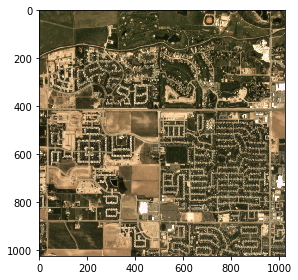

In [17]:
image = io.imread(pd_test_images[0])
#image = io.imread('/home/sebasmos/Desktop/TRPD/DATASET/draft_dataset/test/images_prueba/global_monthly_2018_01_mosaic_L15-0368E-1245N_1474_3210_13.png') 
#print(image.shape)
io.imshow(image)

# 3. Local Satellite imagery with data augmentation

In [74]:
import shutil

CLEAN = False

aug_root = "/home/sebasmos/Desktop/TRPD/DATASET/aug_dataset"    
    
if CLEAN:
    shutil.rmtree(aug_root)
else: 
    shutil.copytree("/home/sebasmos/Desktop/TRPD/DATASET/draft_dataset", aug_root)

In [75]:
def apply_rgbshift(image):
  transform = A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=1)
  augmentations = transform(image = image)
  im = Image.fromarray(augmentations['image'])
  return im

def apply_clahe(image):
  clip_limit=6.0
  tile_grid_size=(16, 16)

  transform = A.CLAHE(clip_limit, tile_grid_size, p=1.0)
  augmentations = transform(image = image)
  im = Image.fromarray(augmentations['image'])
  return im

def apply_rotation(image, mask):
  angle = random.randint(0, 90)
  transform = A.Rotate(limit=[angle, angle], p=1.0, border_mode=cv2.BORDER_CONSTANT)

  augmentations = transform(image = image)
  im = Image.fromarray(augmentations['image'])

  augmentations = transform(image = mask)
  msk = Image.fromarray(augmentations['image'])

  return im, msk

In [76]:
aug_root = "/home/sebasmos/Desktop/TRPD/DATASET/aug_dataset"   
a = 1
b = 1
for path in images_1: # we take images_1 because its the dataset without augmentation: 94 training images
  
  file_name = path.split('/')[-1].replace('.png', '')
  mask_path = aug_root + '/train/masks_prueba/'+file_name+'.png'
  id_image = file_name.split('_mosaic_')[-1]
  
  image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  try:
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
  except:
    print(mask_path)
    continue

  # RGBSHIFT
  if random.random() > 0.8:
    im = apply_rgbshift(image)
    im.save(aug_root +'/train/images_prueba'+'/global_monthly_2021_'+
            str(a).zfill(2)+'_mosaic_'+id_image+'.png')
    msk = Image.fromarray(mask)
    msk.save(aug_root +'/train/masks_prueba/global_monthly_2021_'+str(a).zfill(2)+
              '_mosaic_'+id_image+'.png')
    a += 1

# CLAHE
  if random.random() > 0.8:
    im = apply_clahe(image)
    im.save(aug_root + '/train/images_prueba'+'/global_monthly_2021_'+
            str(a).zfill(2)+'_mosaic_'+id_image+'.png')
    msk = Image.fromarray(mask)
    msk.save(aug_root + '/train/masks_prueba/global_monthly_2021_'+str(a).zfill(2)+
              '_mosaic_'+id_image+'.png')
    a += 1

  # ROTATION
  if random.random() > 0.8:
    im, mask = apply_rotation(image, mask)
    im.save(aug_root + '/train/images_prueba'+'/global_monthly_2021_'+
            str(b).zfill(2)+'_mosaic_'+id_image+'.png')
    mask.save(aug_root + '/train/masks_prueba/global_monthly_2021_'+str(b).zfill(2)+
              '_mosaic_'+id_image+'.png')
    b += 1

print("done")

done


In [77]:
print(aug_root)
masks_aug = glob.glob(aug_root + "/train/masks_prueba/*.png")
images_aug = glob.glob(aug_root+ "/train/images_prueba/*.png")

print(f"Mask len: {len(masks_aug)} - Images len: {len(images_aug)}")

csv_train_images = pd.DataFrame(images_aug)
csv_train_masks = pd.DataFrame(masks_aug)
csv_train_images.to_csv("csv_train_images_aug.csv", header=None)
csv_train_masks.to_csv("csv_train_masks_aug.csv", header=None)  

/home/sebasmos/Desktop/TRPD/DATASET/aug_dataset
Mask len: 148 - Images len: 148


# 4. Satellite imagery with patching setting: 

In [78]:
import numpy as np
from patchify import patchify, unpatchify

CLEAN = False
chip_dim = 256
channels = 3
idx = 0

patching_root = "/home/sebasmos/Desktop/TRPD/DATASET/patching_dataset"    
    
if CLEAN:
    shutil.rmtree(aug_root)
else: 
    if not os.path.exists(patching_root):
        os.makedirs(patching_root)
    # TRAIN folders
    if not os.path.exists(patching_root+"/train/masks_prueba"):# masks
        os.makedirs(patching_root+"/train/masks_prueba")
    if not os.path.exists(patching_root+"/train/images_prueba"):#images
        os.makedirs(patching_root+"/train/images_prueba")
    # TEST folder    
    if not os.path.exists(patching_root+"/test/images_prueba"):#images
        os.makedirs(patching_root+"/test/images_prueba")
    if not os.path.exists(patching_root+"/test/masks_prueba"):#masks
        os.makedirs(patching_root+"/test/masks_prueba")


In [79]:
# Extract IOU
ious = []
for i in images_aug:# take images_aug or masks_aug as they have the same name
    iou = i.split('/')[-1].replace('.png', '')
    ious.append(iou)

In [80]:
ious

['global_monthly_2018_03_mosaic_L15-0358E-1220N_1433_3310_13',
 'global_monthly_2018_07_mosaic_L15-0358E-1220N_1433_3310_13',
 'global_monthly_2019_03_mosaic_L15-0357E-1223N_1429_3296_13',
 'global_monthly_2019_07_mosaic_L15-0357E-1223N_1429_3296_13',
 'global_monthly_2019_02_mosaic_L15-0358E-1220N_1433_3310_13',
 'global_monthly_2019_11_mosaic_L15-0368E-1245N_1474_3210_13',
 'global_monthly_2018_06_mosaic_L15-0368E-1245N_1474_3210_13',
 'global_monthly_2021_02_mosaic_L15-0361E-1300N_1446_2989_13',
 'global_monthly_2019_03_mosaic_L15-0358E-1220N_1433_3310_13',
 'global_monthly_2021_03_mosaic_L15-0358E-1220N_1433_3310_13',
 'global_monthly_2021_20_mosaic_L15-0361E-1300N_1446_2989_13',
 'global_monthly_2021_23_mosaic_L15-0368E-1245N_1474_3210_13',
 'global_monthly_2018_12_mosaic_L15-0357E-1223N_1429_3296_13',
 'global_monthly_2021_35_mosaic_L15-0368E-1245N_1474_3210_13',
 'global_monthly_2019_08_mosaic_L15-0357E-1223N_1429_3296_13',
 'global_monthly_2018_05_mosaic_L15-0358E-1220N_1433_33

In [89]:
def cutter_multidimensional(path_image, path_label,patching_root, chip_dim, channels, ious, idx):

    image = cv2.imread(path_image, cv2.IMREAD_UNCHANGED)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fname  = ious[idx]
    patches_img = patchify(image, (chip_dim, chip_dim, channels), step=chip_dim)  #Step=256 for 256 patches means no overlap
    patches_img = np.squeeze(patches_img)
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i,j,:,:]
            cv2.imwrite(patching_root + '/images_prueba/' + fname+ '_' + str(i)+str(j)+ ".png", single_patch_img)
    
    try:
        mask = cv2.imread(path_label, cv2.IMREAD_UNCHANGED)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = mask[:,:,1].squeeze()
    except:
        print(mask_path)
    
    
    patches_mask = patchify(mask, (chip_dim, chip_dim), step=chip_dim)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i,j,:,:]
            cv2.imwrite(patching_root +'/masks_prueba/' + fname + '_' + str(i)+str(j)+ ".png", single_patch_mask)
            single_patch_mask = single_patch_mask/255
            #print(np.unique(single_patch_mask))

In [90]:
#TRAIN folder
idx = 0
for i in range(len(images_aug)):
    #print(i)
    img = images_aug[i]
    mask = masks_aug[i]
    cutter_multidimensional(img, mask, patching_root+"/train", chip_dim, channels, ious, idx)
    idx +=1

In [91]:
#Test folder
idx = 0
for i in range(len(images_2)):
    #print(i)
    img = images_2[i] # images_2 because its the original testing data without data augmentation
    mask = masks_2[i]
    cutter_multidimensional(img, mask, patching_root+"/test", chip_dim, channels, ious, idx)
    idx +=1

In [92]:
print('INFO_csvs training'.center(50, '-'))
print(patching_root)
masks = glob.glob(patching_root + "/train/masks_prueba/*.png")
images = glob.glob(patching_root+ "/train/images_prueba/*.png")

print(f"TRAIN - Mask len: {len(masks)} - Images len: {len(images)}")

csv_train_images = pd.DataFrame(images)
csv_train_masks = pd.DataFrame(masks)
csv_train_images.to_csv("csv_train_images_aug_patched.csv", header=None)
csv_train_masks.to_csv("csv_train_masks_aug_patched.csv", header=None) 

print('INFO_csvs training'.center(50, '-'))

print(patching_root)
masks = glob.glob(patching_root + "/test/masks_prueba/*.png")
images = glob.glob(patching_root+ "/test/images_prueba/*.png")

print(f"TEST - Mask len: {len(masks)} - Images len: {len(images)}")

csv_train_images = pd.DataFrame(images)
csv_train_masks = pd.DataFrame(masks)
csv_train_images.to_csv("csv_test_images_aug_patched.csv", header=None)
csv_train_masks.to_csv("csv_test_masks_aug_patched.csv", header=None)

----------------INFO_csvs training----------------
/home/sebasmos/Desktop/TRPD/DATASET/patching_dataset
TRAIN - Mask len: 2368 - Images len: 2368
----------------INFO_csvs training----------------
/home/sebasmos/Desktop/TRPD/DATASET/patching_dataset
TEST - Mask len: 624 - Images len: 624


# Visualize images

In [ ]:
sample = train_set[10]

raster_diff = sample['raster_diff']

mask_diff = sample['mask_diff']


print(f"raster_diff: {raster_diff.shape} - mask_diff: {mask_diff.shape}")
images = [raster_diff[1,:,:].squeeze(),mask_diff.squeeze()]

mpl.rcParams['figure.dpi'] = 300
_,axs = plt.subplots(1,2,figsize=(10,10))

titles = ['image','mask']

for i,ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.imshow(images[i]);

In [ ]:
# Testing if images are correct
test_raster_path = Path(os.path.join("../../DATASET/dataset_pruebas/train/",train_set.annotations.images[0]))
test_gdf = gpd.read_file(os.path.join("../../DATASET/dataset_pruebas/train/",train_set.annotations.labels_match_pix[0]))

In [ ]:
def plot_gdf(gdf,fill=False,ax=None,linewidth=0.2):
    if ax is None:
        _,ax = plt.subplots(1,figsize=(3, 3))
        
    for geom in gdf['geometry']:
        if fill:
            patch = PolygonPatch(geom,linewidth=linewidth,color='fuchsia')
            ax.add_patch(patch)
        else:
            ax.plot(*geom.exterior.xy,linewidth=linewidth)
    return(ax)
def plot_sat(path,gdf=None, fill=False,linewidth=0.2):
    f, ax = plt.subplots(1,figsize=(3, 3))
    f.tight_layout()
    
    r = rio.open(path)
    r = r.read()
    r = r.transpose((1,2,0,))
    ax.imshow(r)
    
    if gdf is not None:
        plot_gdf(gdf,fill=fill,ax=ax,linewidth=linewidth)
        
    return(ax)

plot_sat(path=test_raster_path,gdf=test_gdf);

## Vsisualization of [data augmentation](https://github.com/albumentations-team/albumentations) changes



In [ ]:
!pip install -U albumentations --user

In [ ]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        raster_diff, mask_diff = sample['raster_diff'], sample['mask_diff']
        sample['raster_diff'] = torch.from_numpy(raster_diff)
        sample['mask_diff'] = torch.from_numpy(mask_diff)
        
        return sample
        
class AsImage(object):
    """Convert shape of image from (Channels,Rows,Columns) to (Rows,Column,Channels)."""

    def __call__(self, sample):
        raster_diff, mask_diff = sample['raster_diff'], sample['mask_diff']
        sample['raster_diff'] = torch.from_numpy(raster_diff)
        sample['mask_diff'] = torch.from_numpy(mask_diff)
        
        return sample

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
A.Rotate(limit=(-360, 360), interpolation=4, border_mode=4,p=0),

In [ ]:
chip_dimension = 256

transform = A.Compose(
    [
        A.PadIfNeeded(min_height=chip_dimension,min_width=chip_dimension,value=0,p=2),
        A.RandomRotate90(p=1.0),
        ToTensorV2()
    ]
)

In [ ]:
train_set_augmented = Dataloader_trdp(root_dir=root_dir,csv_file=csv_file,chip_dimension=chip_dimension,transform=transform)

In [ ]:
for i in range(len(train_set_augmented)):
    sample = train_set[i]
    # verify dimensionality
    print(sample['raster_diff'].shape, sample['mask_diff'].shape)
    if i==15:
        break